In [1]:
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.tfkeras import Classifiers

import numpy as np

import matplotlib.pyplot as plt
import os
import random

2022-03-21 14:52:50.109986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_dir = "data/classify/train"
val_dir = "data/classify/val"
img_size = (448, 448)
input_channels = 3
n_classes = 2
batch_size = 8

In [3]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

Found 1996 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


/home/gosha20777/anaconda3/envs/nir-2/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


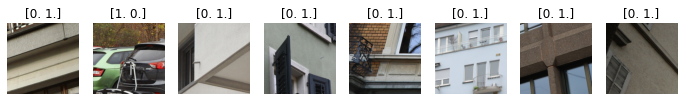

In [4]:
ResNet18, _ = Classifiers.get('resnet18')

def preprocess_image(image):
    return image.astype(np.float32) / 255

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)
    
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)

x_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    s = plt.subplot(4, 8, k+1)
    plt.imshow(img)
    s.set_title(lbl)
    plt.axis('off')

In [5]:
import tensorflow.keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
base_model = ResNet18(input_shape=(448,448,3), weights=None, include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
d = keras.layers.Dense(10, activation='softmax')(x)
output = keras.layers.Dense(n_classes, activation='sigmoid')(d)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2022-03-21 14:52:57.374891: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-21 14:52:57.375584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-21 14:52:57.415743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:52:57.415914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-21 14:52:57.415924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 14:52:57.416785: I tensorflow/stream_executor/platfor

In [7]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("model-resnet.h5", save_best_only=True)
]


model.fit(
    train_generator, 
    epochs=epochs, 
    validation_data=validation_generator, 
    callbacks=callbacks
)

2022-03-21 14:53:07.554429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-21 14:53:07.573928: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3793140000 Hz


Epoch 1/8


2022-03-21 14:53:08.508292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-21 14:53:08.619437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-21 14:53:09.129068: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-21 14:53:09.170283: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


250/250 [==============================] - 43s 114ms/step - loss: 0.5859 - accuracy: 0.7458 - val_loss: 0.5980 - val_accuracy: 0.7250
Epoch 2/8
250/250 [==============================] - 14s 56ms/step - loss: 0.5403 - accuracy: 0.7842 - val_loss: 0.7242 - val_accuracy: 0.5250
Epoch 3/8
250/250 [==============================] - 14s 56ms/step - loss: 0.5172 - accuracy: 0.7987 - val_loss: 0.5322 - val_accuracy: 0.7800
Epoch 4/8
250/250 [==============================] - 14s 56ms/step - loss: 0.4936 - accuracy: 0.8112 - val_loss: 0.8266 - val_accuracy: 0.5000
Epoch 5/8
250/250 [==============================] - 14s 57ms/step - loss: 0.4931 - accuracy: 0.8011 - val_loss: 0.5977 - val_accuracy: 0.7100
Epoch 6/8
250/250 [==============================] - 14s 56ms/step - loss: 0.4996 - accuracy: 0.7919 - val_loss: 0.6167 - val_accuracy: 0.6950
Epoch 7/8
250/250 [==============================] - 14s 57ms/step - loss: 0.4710 - accuracy: 0.8151 - val_loss: 0.4509 - val_accuracy: 0.8150
Epoch 8/

In [8]:
model.predict(x_batch)

array([[0.18073396, 0.8092733 ],
       [0.17957477, 0.81029195],
       [0.17210288, 0.8173869 ],
       [0.17496698, 0.8146475 ],
       [0.30866528, 0.67671245],
       [0.17220813, 0.8172941 ],
       [0.3640782 , 0.6238039 ],
       [0.17302908, 0.8165146 ]], dtype=float32)

In [20]:
from isp.models.unet_1loss import get_model

isp_model = get_model(input_shape=(224, 224, 4))
model.trainable = False
isp_model.load_weights('unet_1loss.h5')

model_mixed=Model(
    inputs=isp_model.inputs,
    outputs=model(isp_model(isp_model.inputs))
)
model_mixed.summary()
model_mixed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 4)]     0         
_________________________________________________________________
model_8 (Functional)         (None, 448, 448, 3)       7767107   
_________________________________________________________________
model_1 (Functional)         (None, 2)                 11192041  
Total params: 18,959,148
Trainable params: 7,767,107
Non-trainable params: 11,192,041
_________________________________________________________________


In [21]:
from isp.utils.image import read_bayer_image
train_dir = "data/classify_raw/train"
val_dir = "data/classify_raw/val"
img_size = (224, 224)
input_channels = 4
n_classes = 2
batch_size = 8

class Loader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, 
            batch_size, 
            img_size,
            base_dir_path,
        ):
        self.batch_size = batch_size
        self.img_size = img_size
        files = []
        
        for f in os.listdir(os.path.join(base_dir_path, 'car')):
            files.append(os.path.join(base_dir_path, 'car', f))
        
        for f in os.listdir(os.path.join(base_dir_path, 'home')):
            files.append(os.path.join(base_dir_path, 'home', f))
        
        random.shuffle(files)
        
        self.files = files
        

    def __len__(self):
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.files[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (4,), dtype="float32")
        y = np.zeros((self.batch_size,) + (2,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            x[j] = read_bayer_image(path)
            if 'car' in path:
                y[j] = np.array([1., 0.])
            else:
                y[j] = np.array([0., 1.])
            
        return x, y

train_gen = Loader(
    batch_size, img_size, train_dir
)

val_gen = Loader(
    batch_size, img_size, val_dir
)

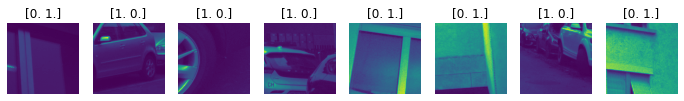

In [22]:
x_batch, y_batch = train_gen.__getitem__(0)

fig = plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    s = plt.subplot(4, 8, k+1)
    plt.imshow(img[:,:,0])
    s.set_title(lbl)
    plt.axis('off')

In [24]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model_mixed.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/5
124/124 [==============================] - 16s 131ms/step - loss: 0.4787 - accuracy: 0.7933 - val_loss: 0.4893 - val_accuracy: 0.8125
Epoch 2/5
124/124 [==============================] - 16s 129ms/step - loss: 0.4455 - accuracy: 0.8236 - val_loss: 0.5141 - val_accuracy: 0.7188
Epoch 3/5
124/124 [==============================] - 16s 129ms/step - loss: 0.4199 - accuracy: 0.8508 - val_loss: 0.4937 - val_accuracy: 0.7812
Epoch 4/5
124/124 [==============================] - 16s 129ms/step - loss: 0.4280 - accuracy: 0.8397 - val_loss: 0.4853 - val_accuracy: 0.7812
Epoch 5/5
124/124 [==============================] - 16s 129ms/step - loss: 0.4164 - accuracy: 0.8468 - val_loss: 0.4615 - val_accuracy: 0.7812


In [26]:
m_model_mixed=Model(
    inputs=model_mixed.inputs,
    outputs=model_mixed.get_layer('model_8').outputs
)

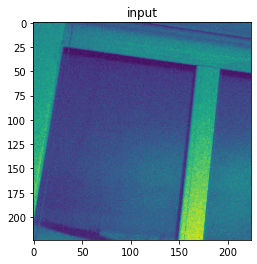

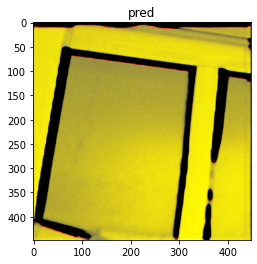

In [30]:
preds = m_model_mixed.predict(x_batch)
plt_display(x_batch[4][:,:,0], 'input')
plt_display(preds[4], 'pred')

In [70]:
m_model_mixed.save('cv-isp.h5')